In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
usage_df = pd.read_csv('imperial_c.csv')

In [3]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
0,92266,Imperial County,1,2015,Residential,147229.0,0.147229
1,92266,Imperial County,1,2016,Residential,142703.0,0.142703
2,92266,Imperial County,1,2017,Residential,135646.0,0.135646
3,92266,Imperial County,1,2018,Residential,138794.0,0.138794
4,92266,Imperial County,1,2019,Residential,154926.0,0.154926


In [4]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ZipCode        120 non-null    int64  
 1   County         120 non-null    object 
 2   Month          120 non-null    int64  
 3   Year           120 non-null    int64  
 4   CustomerClass  120 non-null    object 
 5   TotalkWh       120 non-null    float64
 6   TotalGWh       120 non-null    float64
dtypes: float64(2), int64(3), object(2)
memory usage: 6.7+ KB


In [5]:
# Creating GWh field from converting kWh
usage_df['TotalGWh'] = usage_df['TotalkWh'] / 1000000

In [6]:
# Creating 'Date' column to combine Month and Year
usage_df['Date'] = usage_df['Month'].astype(str) + '-' + usage_df['Year'].astype(str)

In [7]:
usage_df['Date'] = pd.to_datetime(usage_df['Date'], format='%m-%Y')

In [8]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ZipCode        120 non-null    int64         
 1   County         120 non-null    object        
 2   Month          120 non-null    int64         
 3   Year           120 non-null    int64         
 4   CustomerClass  120 non-null    object        
 5   TotalkWh       120 non-null    float64       
 6   TotalGWh       120 non-null    float64       
 7   Date           120 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 7.6+ KB


In [9]:
# Setting 'Date' as the index
usage_df = usage_df.set_index('Date')

In [10]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
Date,,,,,,,
2015-01-01,92266,Imperial County,1,2015,Residential,147229.0,0.147229
2016-01-01,92266,Imperial County,1,2016,Residential,142703.0,0.142703
2017-01-01,92266,Imperial County,1,2017,Residential,135646.0,0.135646
2018-01-01,92266,Imperial County,1,2018,Residential,138794.0,0.138794
2019-01-01,92266,Imperial County,1,2019,Residential,154926.0,0.154926


## Resampling dataframe to total monthly usage

In [11]:
usage = usage_df[['TotalkWh','TotalGWh']].resample('M').sum()

In [12]:
usage.head()

,TotalkWh,TotalGWh
Date,,
2015-01-31,147229.0,0.147229
2015-02-28,101314.0,0.101314
2015-03-31,100669.0,0.100669
2015-04-30,110617.0,0.110617
2015-05-31,127893.0,0.127893


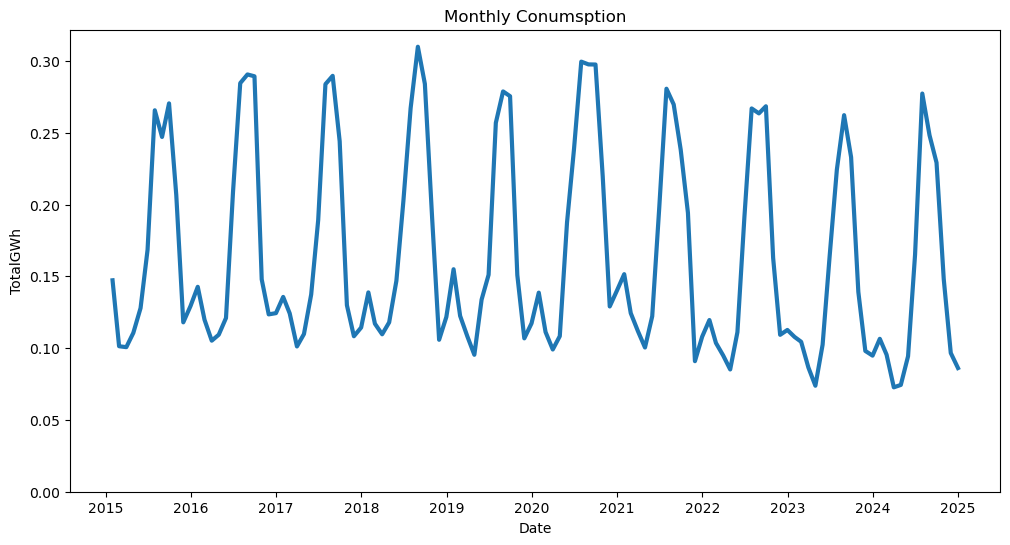

In [13]:
# PLotting data
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], linewidth=3)
plt.title("Monthly Conumsption")
plt.xlabel("Date")
plt.ylabel("TotalGWh")
plt.ylim(ymin=0)
plt.show()

## Implementing SARIMA model

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [15]:
# Checking for stationarity of data

def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
 
 
check_stationarity(usage['TotalGWh'])

ADF Statistic: -1.1904884790525792
p-value: 0.6776738863228373
Non-Stationary


***SARIMAX model can still handle non-stationary data***

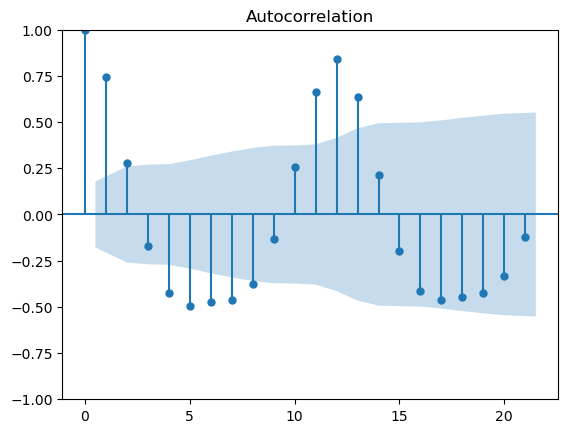

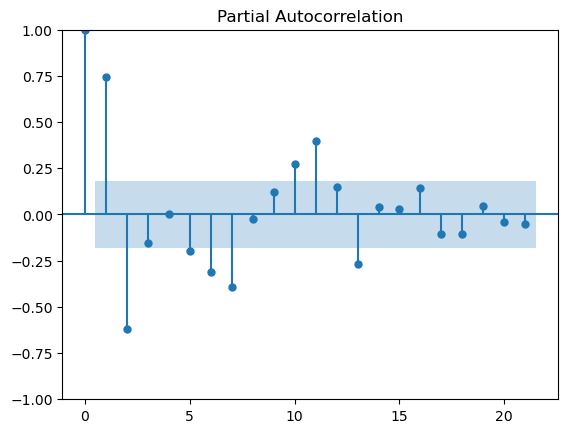

In [16]:
 # Plot ACF and PACF
plot_acf(usage['TotalGWh'])
plot_pacf(usage['TotalGWh'])
plt.show()

## Using AutoArima to find the parameters for SARIMAX model

In [17]:
# Install the library if necessary
# !pip install pmdarima

# Import the library
from pmdarima.arima import auto_arima

# Build and fit the AutoARIMA model
model = auto_arima(usage['TotalGWh'],
                   test='adf',
                   seasonal=True,
                   #max_p=3, max_q=3,
                   start_p=0,
                   d=1,
                   trace=True,
                   start_P=0,
                   m=12,
                   #D=None,
                   stepwise=True,
                   with_intercept=True,
                   suppress_warnings=True)

model.fit(usage['TotalGWh'])

# Check the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,1,1)[12] intercept   : AIC=-541.014, Time=0.70 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=-471.653, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=-503.556, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-541.296, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-473.653, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=-498.628, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=-536.435, Time=0.77 sec
 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=-521.703, Time=0.58 sec
 ARIMA(0,1,1)(1,1,2)[12] intercept   : AIC=-537.774, Time=0.52 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=-525.950, Time=0.50 sec
 ARIMA(1,1,2)(0,1,1)[12] intercept   : AIC=-536.384, Time=0.42 sec
 ARIMA(0,1,1)(0,1,1)[12]          

In [18]:
# p, d, q parameters
model.order

(0, 1, 1)

In [19]:
# P, D, Q, s parameters
model.seasonal_order

(0, 1, 1, 12)

In [20]:
# Define SARIMA parameters from AutoArima results
# Fit the SARIMA model
model = SARIMAX(usage['TotalGWh'], order=model.order, seasonal_order=model.seasonal_order)
results = model.fit()
model

### Forecasting the next 12 months

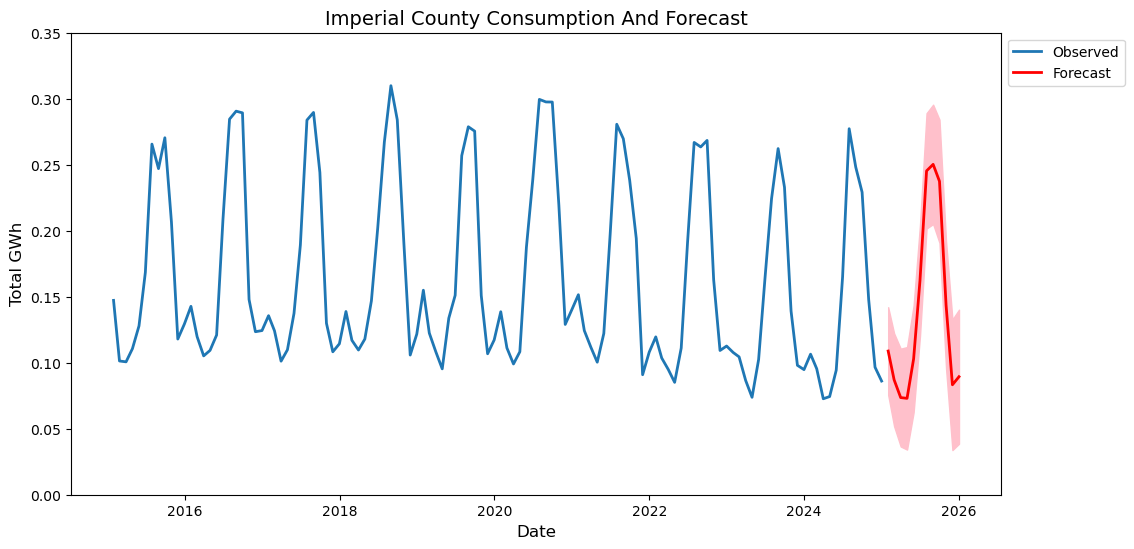

In [21]:
# Forecast future demand
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed',linewidth=2)
plt.plot(forecast_mean, label='Forecast', color='red',linewidth=2)
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Imperial County Consumption And Forecast", fontsize=14)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Total GWh",fontsize=12)
plt.ylim(ymin=0,ymax=0.35)
plt.legend(bbox_to_anchor=(1.14,1), loc='upper right')
plt.show()

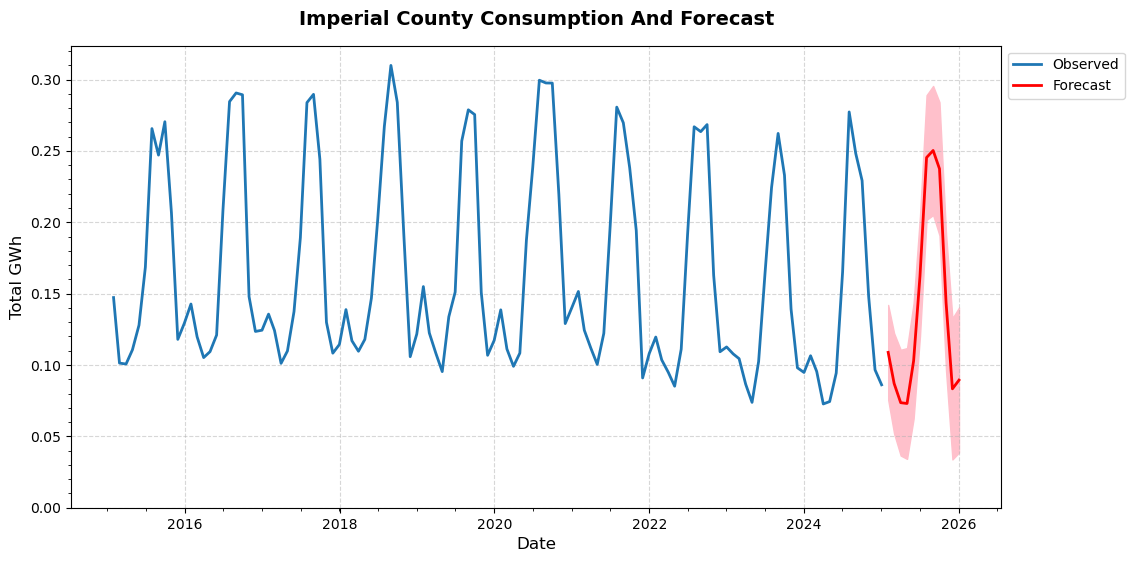

In [22]:
# Alternative Plot
from matplotlib.ticker import AutoMinorLocator


# Plot settings
plt.figure(figsize=(12, 6))
ax1 = sns.lineplot(data=usage['TotalGWh'], label='Observed',linewidth=2)
ax2 = sns.lineplot(data=forecast_mean, label='Forecast', color='red', linewidth=2)

# Fill between forecast confidence intervals
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')


# Plot labels and legend
plt.title("Imperial County Consumption And Forecast", weight='bold', fontsize=14, pad=15)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Total GWh",fontsize=12)
plt.ylim(bottom=0)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.14,1), loc='upper right')

# Show plot
#plt.savefig('imperial_c.png')
plt.show()

### Evaluate Model

In [23]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 0.0072854626116563995
MSE: 0.0001215822071810473
RMSE: 0.01102643220543469


In [24]:
observed

Date
2024-01-31    0.106481
2024-02-29    0.095438
2024-03-31    0.072699
2024-04-30    0.074370
2024-05-31    0.094350
2024-06-30    0.165015
2024-07-31    0.277276
2024-08-31    0.248218
2024-09-30    0.229166
2024-10-31    0.147876
2024-11-30    0.096602
2024-12-31    0.086115
Freq: M, Name: TotalGWh, dtype: float64

In [25]:
forecast_mean

2025-01-31    0.108842
2025-02-28    0.087061
2025-03-31    0.073589
2025-04-30    0.073020
2025-05-31    0.102957
2025-06-30    0.162296
2025-07-31    0.245331
2025-08-31    0.250278
2025-09-30    0.237422
2025-10-31    0.143625
2025-11-30    0.083285
2025-12-31    0.089405
Freq: M, Name: predicted_mean, dtype: float64

### Forecasting the next 24 months

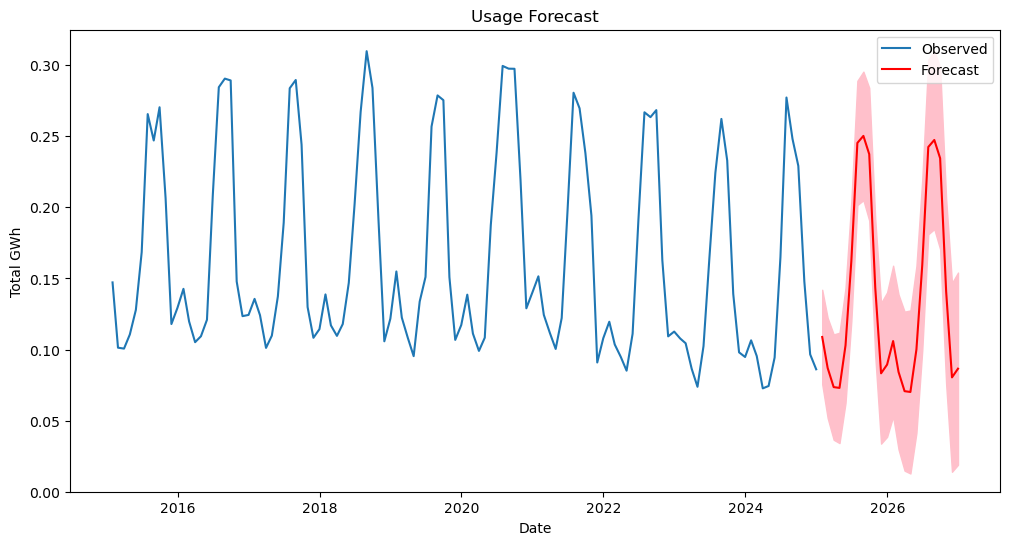

In [26]:
# Forecast future demand
forecast_periods = 24  # Forecast the next 24 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(ymin=0)
plt.legend()
plt.show()

### Evaluate Model

In [27]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 0.007926342287562447
MSE: 0.00012959957644423725
RMSE: 0.011384180973800322


In [28]:
observed

Date
2023-01-31    0.107763
2023-02-28    0.104423
2023-03-31    0.086521
2023-04-30    0.073807
2023-05-31    0.102420
2023-06-30    0.163837
2023-07-31    0.224287
2023-08-31    0.262219
2023-09-30    0.232948
2023-10-31    0.139151
2023-11-30    0.098034
2023-12-31    0.094771
2024-01-31    0.106481
2024-02-29    0.095438
2024-03-31    0.072699
2024-04-30    0.074370
2024-05-31    0.094350
2024-06-30    0.165015
2024-07-31    0.277276
2024-08-31    0.248218
2024-09-30    0.229166
2024-10-31    0.147876
2024-11-30    0.096602
2024-12-31    0.086115
Freq: M, Name: TotalGWh, dtype: float64

In [29]:
forecast_mean

2025-01-31    0.108842
2025-02-28    0.087061
2025-03-31    0.073589
2025-04-30    0.073020
2025-05-31    0.102957
2025-06-30    0.162296
2025-07-31    0.245331
2025-08-31    0.250278
2025-09-30    0.237422
2025-10-31    0.143625
2025-11-30    0.083285
2025-12-31    0.089405
2026-01-31    0.105985
2026-02-28    0.084204
2026-03-31    0.070732
2026-04-30    0.070163
2026-05-31    0.100100
2026-06-30    0.159439
2026-07-31    0.242474
2026-08-31    0.247421
2026-09-30    0.234565
2026-10-31    0.140768
2026-11-30    0.080428
2026-12-31    0.086548
Freq: M, Name: predicted_mean, dtype: float64

In [30]:
customer_consum = usage_df.groupby('CustomerClass')['TotalGWh'].sum()
customer_consum

CustomerClass
Residential    19.620032
Name: TotalGWh, dtype: float64

In [31]:
customer_df = customer_consum.reset_index()
customer_df

,CustomerClass,TotalGWh
0,Residential,19.620032


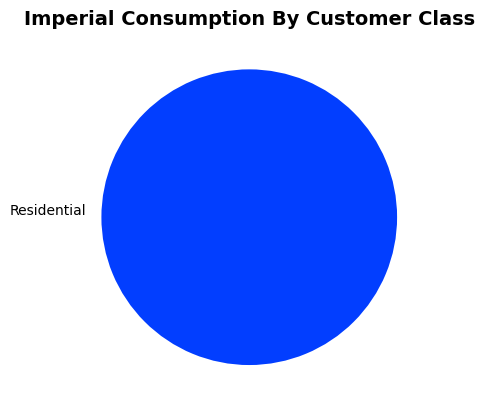

In [32]:
# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'], labels=customer_df['CustomerClass'], rotatelabels=True
       ,colors=palette_color)
plt.title('Imperial Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
plt.show()